# Mlflow setup test

This notebook is used to test the mlflow setup with a dummy classification experiment.

In [1]:
import mlflow
import dagshub
from mlflow.tracking import MlflowClient
import os

from dotenv import load_dotenv, find_dotenv

# Automatically find and load .env file from any parent directory
load_dotenv(find_dotenv())

DAGSHUB_USER_NAME = os.getenv("DAGSHUB_USER_NAME")
DAGSHUB_TOKEN = os.getenv("DAGSHUB_TOKEN")
# tracking_uri = os.getenv("MLFLOW_TRACKING_URI")
DAGSHUB_REPO = os.getenv("DAGSHUB_REPO")


# ✅ Set credentials and tracking URI
# os.environ["MLFLOW_TRACKING_USERNAME"] = DAGSHUB_USER_NAME
os.environ["MLFLOW_TRACKING_PASSWORD"] = DAGSHUB_TOKEN
# os.environ['MLFLOW_TRACKING_URI']=f"https://dagshub.com/{DAGSHUB_USER_NAME}/{DAGSHUB_REPO}.mlflow"
# tracking_uri = os.environ['MLFLOW_TRACKING_URI']
# mlflow.set_tracking_uri(tracking_uri)

# mlflow.set_experiment("socialsphere_classification")

# Initialize DagsHub tracking
dagshub.init(repo_owner=DAGSHUB_USER_NAME, repo_name=DAGSHUB_REPO, mlflow=True)

# Set tracking URI to local directory
# mlflow.set_tracking_uri("file:../mlruns")  # Adjust path as needed if notebook is nested

# Set experiment
# mlflow.set_experiment("Test_Classification2")

# Create or get experiment
experiment_name = "Classification_Conflicts"
mlflow.set_experiment(experiment_name)
# DAGSHUB_TOKEN
print(DAGSHUB_TOKEN)
print(DAGSHUB_USER_NAME)
print(DAGSHUB_REPO)
# print(tracking_uri)

Accessing as bab-git

Initialized MLflow to track repo "bab-git/SDS-social-sphere"

Repository bab-git/SDS-social-sphere initialized!

f15e997b9299f1ec88303326e6e9474869c628e8
bab-git
SDS-social-sphere


In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import mlflow.sklearn
import shutil

# dagshub.init('bab-git', 'SDS-social-sphere')
# mlflow.set_tracking_uri('https://dagshub.com/bab-git/SDS-social-sphere.mlflow')
# mlflow.sklearn.autolog()

# Minimal dummy data
X = pd.DataFrame({"feature1": [1, 0, 1, 0], "feature2": [0, 1, 1, 0]})
y = [1, 0, 1, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

from mlflow.models.signature import infer_signature



with mlflow.start_run():
    clf = DummyClassifier(strategy="most_frequent")
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)

    signature = infer_signature(X_test, preds)
    
    mlflow.log_param("strategy", "most_frequent")
    mlflow.log_metric("accuracy", acc)

    # 1) save locally
    shutil.rmtree("tmp_model", ignore_errors=True)
    # mlflow.sklearn.save_model(clf, path="tmp_model")
    # 2) push as artifacts
    # mlflow.log_artifacts("tmp_model", artifact_path="my_model")

    mlflow.sklearn.log_model(
        clf, 
        artifact_path="dummy_model", 
        signature=signature,
        input_example=X_test.iloc[0:1]
        )


/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run charming-yak-137 at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2/runs/6f6ace86cfda4e73af2e5625c7107754
🧪 View experiment at: https://dagshub.com/bab-git/SDS-social-sphere.mlflow/#/experiments/2


# Using registered model from MLflow

## Loading the model

In [15]:
import mlflow
# from mlflow.models import Model
import sys
sys.path.append('../src')
import regression

# model_uri = 'runs:/a7f3a1fd156443e58e7554ac1e8b53fa/model' # conflict_catboost_multiclass
model_uri = 'runs:/3edb39904209419ab4d30ea0a00b79f1/model' # catboost_binary_classifier
# model_uri = 'runs:/83b6b586aa6048ac85ba95485b5a50a0/model' # conflict logistic
# model_uri = 'runs:/594b916daee046ff8f9fa0ed3aed8748/model' # addicted_score_baseline

artifact_path = "shap_summary.png"
# The model is logged with an input example
pyfunc_model = mlflow.pyfunc.load_model(model_uri)
input_data = pyfunc_model.input_example

print("Input data:")
input_data.head()

Input data:


,Age,Gender,Academic_Level,Country,Daily_Usage,Platform,Academic_Affects,Sleep_Hrs,Mental_Health,Relationship_Status
0,20,Female,Undergraduate,Bangladesh,4.9,Instagram,Yes,6.4,5,Single
1,20,Female,Undergraduate,UAE,6.9,Instagram,Yes,6.1,5,In Relationship
2,21,Male,Graduate,UK,5.0,Facebook,Yes,6.6,6,In Relationship
3,20,Female,Undergraduate,Ireland,4.5,TikTok,Yes,7.4,7,Single
4,21,Female,Undergraduate,India,5.8,TikTok,Yes,5.9,6,In Relationship


## Predicting with the model

In [20]:
# 1️⃣ Get predictions directly
predictions = pyfunc_model.predict(input_data)

print("\nPrediction results:")
print(predictions)


Prediction results:
[1 1 1 1 1]


## SHAP analysis

In [ ]:
import mlflow.pyfunc, mlflow.sklearn
import shap
import pandas as pd

# 1) Load the PyFunc to get your input_example
# model_uri = "runs:/594b916daee046ff8f9fa0ed3aed8748/model"
pyfunc_model = mlflow.pyfunc.load_model(model_uri)
input_df = pyfunc_model.input_example

import pickle
with open('../data/data_cleaned.pickle', 'rb') as f:
    input_df = pickle.load(f)
# input_df
# 2) Load the sklearn Pipeline for SHAP
pipe = mlflow.sklearn.load_model(model_uri)


In [26]:
# Use the sklearn pipeline (pipe) to predict using a sample row from input_df
sample = input_df.iloc[0:10]
pipe_prediction = pipe.predict(sample)
print("Pipeline prediction for sample row:")
print(pipe_prediction)


Pipeline prediction for sample row:
[1 0 1 0 0 1 1 0 0 1]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Model name: CatBoostClassifier
CatBoost SHAP plot type: bar


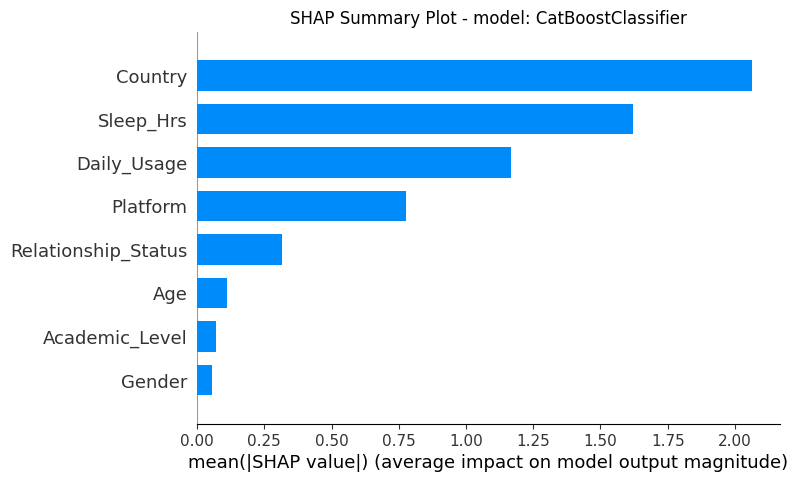

In [ ]:
# --- IPython/Jupyter Extensions ---
%load_ext autoreload
%autoreload 2
from utils import run_shap_experiment
from sklearn.pipeline import Pipeline

# model_type="regression"
model_type="classification" 
# feature_perturbation = "tree_path_dependent"

sample = input_df.iloc[0:1]
run_shap_experiment(
    best_model=pipe,
    X_train_full=sample,    
    plot_type='violin', # other options: "bar", "dot", "violin"
    shap_type='tree',
    # feature_perturbation=feature_perturbation,
    model_type=model_type,
    figsize=(8, 5)
)

In [6]:

# 3) Define a background for SHAP (here we sample up to 100 rows from your example set)
n_bg = min(len(input_df), 100)
background = input_df.sample(n_bg, random_state=42)

model   = pipe.named_steps['classifier']
preprocessor = pipe.named_steps['preprocessing']

from utils import get_feature_names
from scipy import sparse

# 4) Create a TreeExplainer around your pipeline
explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")

# 5) Choose a single row to explain
sample = input_df.iloc[0:1]
sample = input_data.sample(n=200)
X_shap_proc = preprocessor.transform(sample)
if sparse.issparse(X_shap_proc):
    X_shap_proc = X_shap_proc.toarray()
plot_type = "bar" 
feature_names = get_feature_names(preprocessor)
X_shap_df = pd.DataFrame(X_shap_proc, columns=feature_names)
# 6) Compute SHAP values
shap_values = explainer.shap_values(X_shap_df)

# 7) Plot (waterfall for the first output)
shap.summary_plot(
    shap_values, X_shap_df, plot_type=plot_type, show=False, max_display=15
)
# fig.savefig("shap_single_waterfall.png")


ValueError: Cannot take a larger sample than population when 'replace=False'